After Ordered Transformation PR

https://discourse.pymc.io/t/sampling-uniformly-in-a-triangular-support/765/

In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import seaborn as sns
import pystan

%pylab inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
with pm.Model() as m:
    x = pm.Uniform('x', 0., 1., shape=2)
    pm.Potential('ordered', tt.switch(x[1]-x[0] < 0, -np.inf, 0))
    tr = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_interval__]
INFO:pymc3:NUTS: [x_interval__]
100%|██████████| 1000/1000 [00:01<00:00, 845.76it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '4870' (I am process '4871')
INFO:theano.gof.compilelock:Waiting for existing lock by process '4870' (I am process '4871')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '4870' (I am process '4872')
INFO

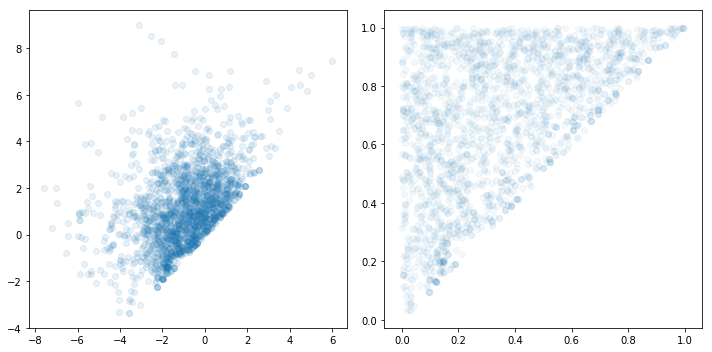

In [3]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr['x_interval__'][:, 0], tr['x_interval__'][:, 1], alpha=.1)
ax[1].scatter(tr['x'][:, 0], tr['x'][:, 1], alpha=.05)
plt.tight_layout();

In [4]:
def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

def normcdf1(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.cos(angle) * thetap1) - (np.sin(angle) * tt.abs_(thetap2)))

def normcdf2(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.sin(angle) * thetap1) + (np.cos(angle) * tt.abs_(thetap2)))

with pm.Model() as m1:
    thetap = pm.MvNormal('thetap', mu=0., cov=np.eye(2), shape=2)
    
    x1 = pm.Deterministic('x1', normcdf1(thetap[0], thetap[1]))
    x2 = pm.Deterministic('x2', normcdf2(thetap[0], thetap[1]))

    tr1 = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetap]
INFO:pymc3:NUTS: [thetap]
100%|██████████| 1000/1000 [00:01<00:00, 979.51it/s]


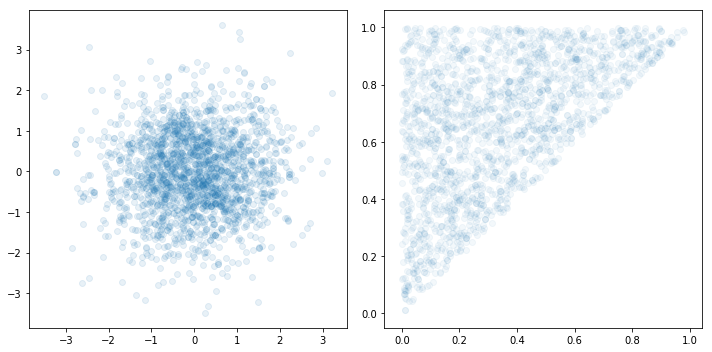

In [5]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr1['thetap'][:, 0], tr1['thetap'][:, 1], alpha=.1)
ax[1].scatter(tr1['x1'], tr1['x2'], alpha=.05)
plt.tight_layout();

In [6]:
datadict = {}
datadict['N'] = 2
stan_m = """
    data {
        int<lower=1> N;
    }
    parameters {
        ordered[N] x;
    }
    model {
        x ~ uniform(0, 1);
        // target += uniform_lpdf(x | 0, 1);
    }
    """

tr_stan = pystan.stan(model_code=stan_m, data=datadict,
                      iter=5000, warmup=1000, 
                      chains=4, n_jobs=4, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a354c77b7a6aa37371be175bb3cd19cd NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1816:0,
                 from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmphqgw9z7c/stanfit4anon_model_a354c77b7a6aa37371be175bb3cd19cd_396097373767393464.cpp:599:
/usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /usr/local/lib/python3.5/dist-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0/boost/multi_array/base.hpp:28:0,
                 from /usr/local/lib/python3.5/di

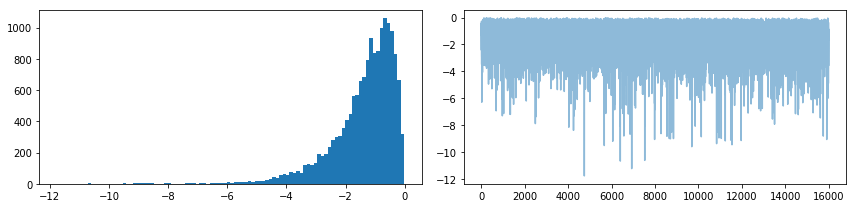

In [7]:
tr_x = tr_stan.extract()['x']
lnp = tr_stan.extract()['lp__']

_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

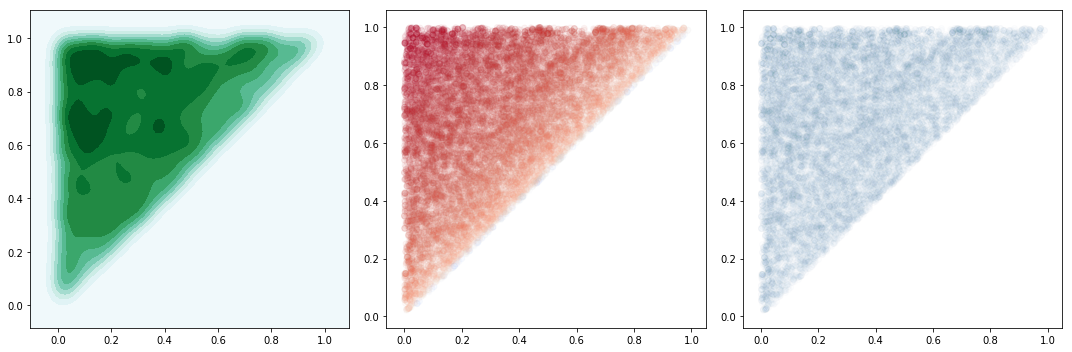

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(tr_x[:, 0], tr_x[:, 1], shade=True, ax=ax[0])
ax[1].scatter(tr_x[:, 0], tr_x[:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(tr_x[:, 0], tr_x[:, 1], alpha=.01)
plt.tight_layout();

In [9]:
x = np.random.rand(1, 5).squeeze()
x

array([0.37945077, 0.90417022, 0.99192143, 0.30334021, 0.6013039 ])

In [10]:
def backward1(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        if i>0:
            y[i] = y[i-1] + np.exp(x[i])
    return y

y = backward1(x)
y

array([0.37945077, 2.84933238, 5.54574285, 6.90011801, 8.72461423])

In [11]:
def backward2(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    y[1:] = np.exp(x[1:])
    return np.cumsum(y)

y = backward2(x)
y

array([0.37945077, 2.84933238, 5.54574285, 6.90011801, 8.72461423])

In [12]:
def forward2(y):
    x = np.zeros_like(y)
    x[0] = y[0]
    x[1:] = np.log(y[1:] - y[:-1])
    return x

x2 = forward2(y)
x2

array([0.37945077, 0.90417022, 0.99192143, 0.30334021, 0.6013039 ])

In [13]:
class Chained(pm.distributions.transforms.Transform):
    def __init__(self, transform_list):
        self.transform_list = transform_list
        self.name = '_'.join([transf.name for transf in self.transform_list])

    def forward(self, x):
        y = x
        for transf in self.transform_list:
            y = transf.forward(y)
        return y

    def forward_val(self, x, point=None):
        y = x
        for transf in self.transform_list:
            y = transf.forward_val(y)
        return y

    def backward(self, y):
        x = y
        for transf in reversed(self.transform_list):
            x = transf.backward(x)
        return x

    def jacobian_det(self, y):
        y_ = y
        det = 0.
        for transf in reversed(self.transform_list):
            det += tt.sum(transf.jacobian_det(y_))
            y_ = transf.backward(y_)
        return det

In [14]:
Order = pm.distributions.transforms.Ordered()
upper, lower = 0., 1.
Interval = pm.distributions.transforms.Interval(upper, lower)
Logodd = pm.distributions.transforms.LogOdds()
chain_tran = Chained([Logodd, Order])

In [15]:
with pm.Model() as m2:
    x = pm.Uniform('x', 0., 1., shape=2,
                   transform=chain_tran,
                   testval=[0.1, 0.9])
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_logodds_ordered__]
INFO:pymc3:NUTS: [x_logodds_ordered__]
100%|██████████| 6000/6000 [00:04<00:00, 1342.31it/s]
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6899516914491187, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc

In [16]:
varnames = tr2.varnames
varnames

['x_logodds_ordered__', 'x', 'jacobian']

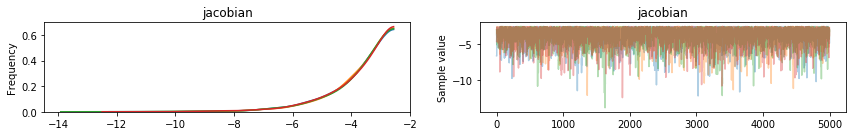

In [17]:
pm.traceplot(tr2, varnames=['jacobian']);

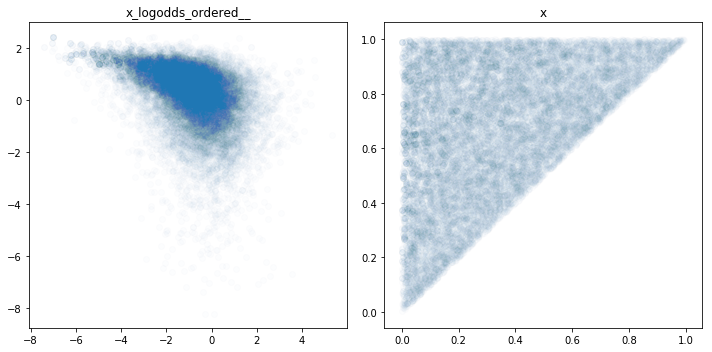

In [18]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(tr2[varname][:, 0], tr2[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [19]:
with pm.Model() as mtest:
    x = pm.Flat('x_logodds_ordered__', shape=2, testval=[2., 1.])
    
    x1 = Order.backward(x)
    x2 = pm.Deterministic('x', Logodd.backward(x1))
    
    pm.Potential('p1', Order.jacobian_det(x))
    pm.Potential('logp', pm.Uniform.dist(upper, lower).logp(x2))
    pm.Potential('p2', Logodd.jacobian_det(x1))
    
    pm.Deterministic('jacobian', Order.jacobian_det(x) + tt.sum(Logodd.jacobian_det(x1)))
    
    trtest = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_logodds_ordered__]
INFO:pymc3:NUTS: [x_logodds_ordered__]
100%|██████████| 6000/6000 [00:04<00:00, 1222.87it/s]
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or 

In [20]:
varnames = trtest.varnames
varnames

['x_logodds_ordered__', 'x', 'jacobian']

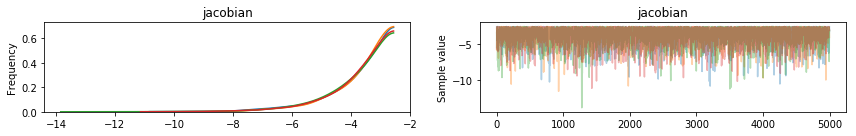

In [21]:
pm.traceplot(trtest, varnames=['jacobian']);

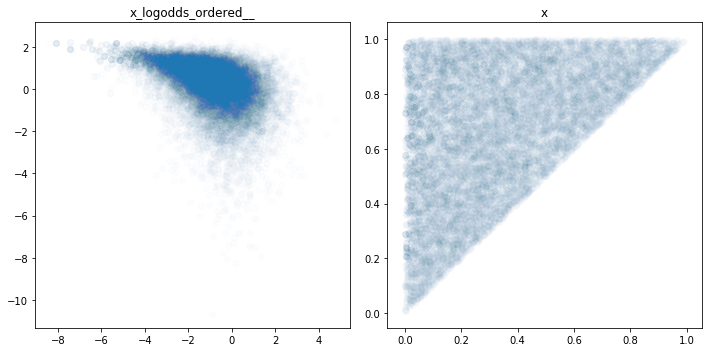

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(trtest[varname][:, 0], trtest[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

The Jacobian computed by hand seems to be correct, now try to pin down where went wrong when chaining the transformation together

In [23]:
x = np.asarray([2., 1.])
det = Order.jacobian_det(x) + tt.sum(Logodd.jacobian_det(Order.backward(x)))
det.eval()

array(-5.98991959)

In [24]:
chain_tran.jacobian_det(x).eval()

array(-5.98991959)

In [25]:
# testpoint = m2.test_point
testpoint = mtest.test_point
testpoint

{'x_logodds_ordered__': array([2., 1.])}

In [26]:
m2.logp(testpoint)

array(-5.98991959)

In [27]:
mtest.logp(testpoint)

array(-5.98991959)

In [28]:
factors = [var.logpt for var in m2.basic_RVs] + m2.potentials
func1 = theano.function(m2.basic_RVs, factors)
func1(np.asarray([2., 1.]))

[array(-5.98991959)]

In [29]:
factors = [var.logpt for var in mtest.basic_RVs] + mtest.potentials
func2 = theano.function(mtest.basic_RVs, factors)
func2(np.asarray([2., 1.]))

[array(0.), array(1.), array([0., 0.]), array([-2.25385602, -4.73606357])]

In [30]:
np.sum([np.sum(out) for out in func2(np.asarray([2., 1.]))])

-5.989919587258818

In [31]:
x0 = m2.basic_RVs[0]
x0.distribution.logp(x).eval()

array(-5.98991959)

In [32]:
logp = m2.logp
lnp = np.array([logp(tr2.point(i,chain=c)) for c in tr2.chains for i in range(len(tr2))])

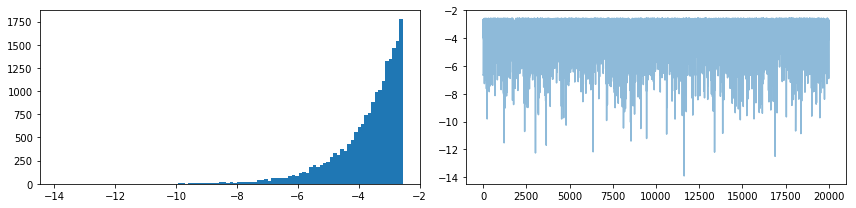

In [33]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

In [34]:
logp = mtest.logp
lnp = np.array([logp(trtest.point(i,chain=c)) for c in trtest.chains for i in range(len(trtest))])

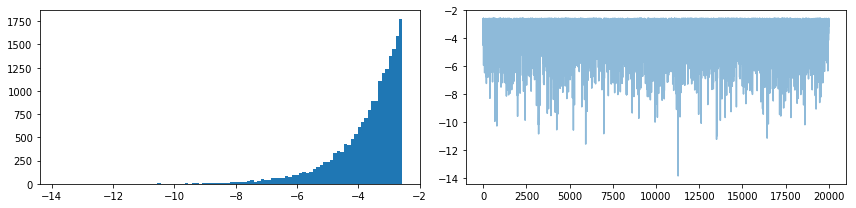

In [35]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

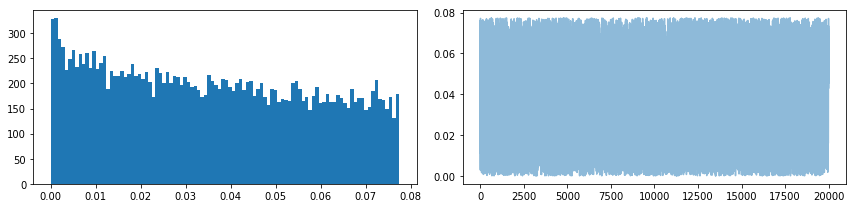

In [36]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(np.exp(lnp), 100)
ax[1].plot(np.exp(lnp), alpha=.5);
plt.tight_layout();

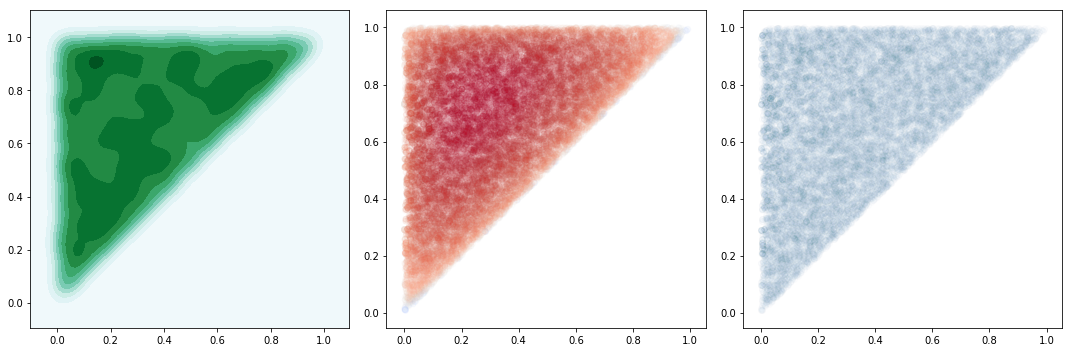

In [37]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

varname = 'x'
sns.kdeplot(trtest[varname][:, 0], trtest[varname][:, 1], shade=True, ax=ax[0])
ax[1].scatter(trtest[varname][:, 0], trtest[varname][:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(trtest[varname][:, 0], trtest[varname][:, 1], cmap=plt.cm.coolwarm,
           alpha=.01)
plt.tight_layout();

In [38]:
import tensorflow as tf
from tensorflow.contrib.distributions.python.ops.bijectors.ordered import Ordered as tfOrdered
from tensorflow.contrib.distributions.python.ops.bijectors.sigmoid import Sigmoid as tfSigmoid
from tensorflow.contrib.distributions.python.ops.bijectors.chain import Chain as tfChain

from scipy import special
import numpy as np
# x = np.asarray([1.88535668, -1.34137155, -1.07726682, -0.4407823, -1.70935385])
# y = special.expit(x)
y = np.sort(np.random.rand(5))

tfsigmoid = tfSigmoid()
tfordered = tfOrdered()
tfchain = tfChain((tfsigmoid, tfordered))

sess = tf.Session()

In [39]:
sess.run(tfsigmoid.inverse(y))

array([-1.18041346, -0.54120144, -0.27378756,  0.22327514,  1.66286104])

In [40]:
sess.run(tfchain.inverse(y))

array([-1.18041346, -0.59836492,  0.1621287 ,  1.4122932 ,  6.68667269])

In [41]:
sess.run(tfordered.inverse(tfsigmoid.inverse(y)))

array([-1.18041346, -0.59836492,  0.1621287 ,  1.4122932 ,  6.68667269])

In [42]:
sess.run(tfchain.inverse_log_det_jacobian(y, event_ndims=1))

9.05969988169841

In [43]:
sess.run(tfsigmoid.inverse_log_det_jacobian(y, event_ndims=1))

7.988552695285273

In [44]:
sess.run(tfordered.inverse_log_det_jacobian(tfsigmoid.inverse(y), event_ndims=1))

1.0711471864131363

In [45]:
class Sigmoid(pm.distributions.transforms.Transform):
    name = "sigmoid"

    def backward(self, y):
        return tt.log(y) - tt.log1p(-y)

    def forward(self, x):
        return tt.nnet.sigmoid(x)

    def forward_val(self, x, point=None):
        return special.expit(x)

    def jacobian_det(self, y):
        return -tt.log(y) - tt.log1p(-y)

In [46]:
ordered = pm.distributions.transforms.Ordered()
sigmoid = Sigmoid()
chain_tran = Chained([ordered, sigmoid])
chain_tran.jacobian_det(y).eval()

array(9.05969988)

In [47]:
sigmoid.jacobian_det(y).sum().eval()

array(7.9885527)

https://discourse.pymc.io/t/order-statistics-in-pymc3/617/3

[4 3 0 2 1]
[[2 2 3 4 4 2 4 1 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 4 4 2 4 2]
 [0 4 4 2 2 4 3 2 3 4 4 4 1 4 2 3 4 3 3 3 3 4 3 1 3 3 3 3 2 4]
 [4 1 2 3 3 1 1 4 4 3 1 3 4 0 3 4 3 4 4 4 4 1 4 4 1 2 2 4 3 1]
 [3 3 1 0 0 0 2 3 0 1 3 1 3 3 1 1 1 0 1 1 0 3 1 0 4 0 1 1 0 3]
 [1 0 0 1 1 3 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 3 0 1 0 0 1 0]]


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [latent_ordered__, mu_hat]
INFO:pymc3:NUTS: [latent_ordered__, mu_hat]
100%|██████████| 1000/1000 [00:14<00:00, 69.97it/s]


The true ranking is: 
[4 3 0 2 1]
The Latent mean is: 
[ 0.    0.72  0.18 -1.03 -2.  ]
The estimated ranking is: 
[4 3 0 2 1]


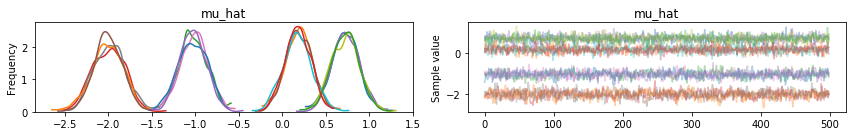

In [48]:
# data
K = 5 # number of items being ranked
J = 100 # number of raters
yreal = np.argsort(np.random.randn(1, K), axis=-1)
print(yreal.squeeze())
y = np.argsort(yreal + np.random.randn(J, K), axis=-1)
print(y[:30, :].T)

# transformed data
y_argsort = np.argsort(y, axis=-1)

with pm.Model():
    mu_hat = pm.Normal('mu_hat', 0, 1, shape=K-1)
    # set first value to 0 to avoid unidentified model
    mu = tt.concatenate([[0.], mu_hat])
    #sd = pm.HalfCauchy('sigma', 1.)
    latent = pm.Normal('latent',
                       mu=mu[y_argsort],
                       sd=1., # using sd does not work yet
                       transform=ordered, 
                       shape=y_argsort.shape,
                       testval=np.repeat(np.arange(K)[:,None], J, axis=1).T)
                        # There are some problems with Ordered 
                        # right now, you need to give a testval
    trace = pm.sample()
pm.traceplot(trace, varnames=['mu_hat']);

print('The true ranking is: ')
print(yreal.flatten())
print('The Latent mean is: ')
latentmu = np.hstack(([0], pm.summary(trace, varnames=['mu_hat'])['mean'].values))
print(np.round(latentmu,2))
print('The estimated ranking is: ')
print(np.argsort(latentmu))